In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
# import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Load the data

df_train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
df_test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

# **1. Exploratory Data Analysis (EDA)**
1. **Shape of data.**
* > df_train.shape = (162758, 5)
* > df_test.shape = (55315, 4)
* > movies.shape = (143258, 14)

2. **Distribution of sentiments.**
* Positive dominant over Negative.

3. **Text Length Analysis.**
4. **Sentiment Correlations.**

# **Check data samples**

In [4]:
df_train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


**1.Shape of data.**

In [5]:
# Shape of train, test and movies data.

df_train.shape, df_test.shape, movies.shape

((162758, 5), (55315, 4), (143258, 14))

In [6]:
df_test.columns.tolist()

['movieid', 'reviewerName', 'isTopCritic', 'reviewText']

**2. Distribution on sentiments.**

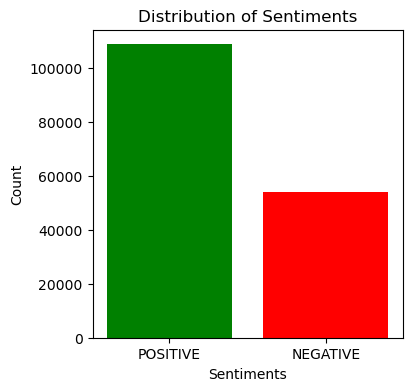

In [7]:
# Distribution of 'Positive' and 'Negative' sentiments.
sentiment_counts = df_train['sentiment'].value_counts()

# Plot the distribution of sentiments
plt.figure(figsize=(4,4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()


**3. Text Analysis of train data.**
>     In this we take a deep look how text will look inside 'reviewText'. Whether they have null value, length of text, and describe over 'reviewText'.

In [8]:
df_train.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [9]:
# Fill NaN values in the 'text' column with 'NA'.
df_train['reviewText'] = df_train['reviewText'].fillna('NA')

# Convert 'text' column to string to handle potential float values.
df_train['reviewText'] = df_train['reviewText'].astype(str)

**We fill 'NA' to null value of reviewText of df_train.**

# **Bar chart**
**Visualization on most-frequent text on train data.**

[('the', 179656), ('and', 109468), ('of', 104327), ('to', 72956), ('is', 64514), ('it', 62725), ('in', 51515), ('that', 44638), ('as', 30401), ('but', 30125), ('with', 30101), ('film', 26858), ('for', 26043), ('this', 25866), ('an', 21528), ('its', 21166), ('movie', 18222), ('you', 17965), ('on', 17850), ('be', 16004)]


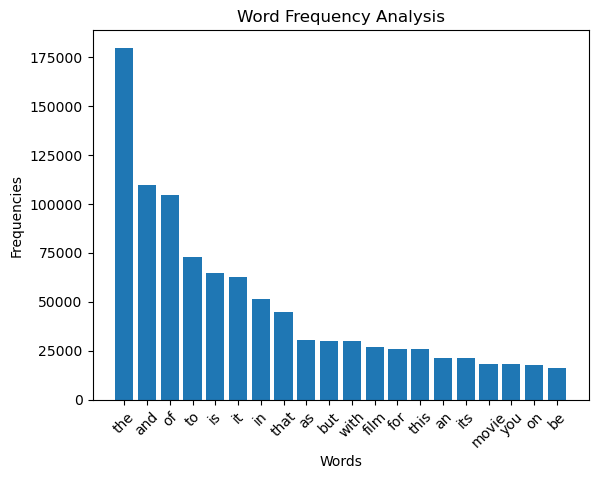

In [10]:
# Combine all text into a single list
all_text = df_train['reviewText'].tolist()

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data into a matrix of word counts
word_counts_matrix = vectorizer.fit_transform(all_text)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Sum the word counts across all reviews
word_frequencies = word_counts_matrix.sum(axis=0).tolist()[0]

# Create a dictionary to store word frequencies with their respective words
word_freq_dict = dict(zip(words, word_frequencies))

# Get the most common words and their frequencies
most_common_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# word_freq_dict.items(): 
# This method returns a view object that displays 
# a list of key-value pairs (words and their frequencies) in the word_freq_dict.

# Print the most common words and their frequencies
print(most_common_words)

# Visualize word frequency using a bar chart
words, frequencies = zip(*most_common_words)
# unzip the list of tuples.
plt.bar(words, frequencies)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Word Frequency Analysis')
plt.show()


**3.1 Text Analysis on test data.**
>     In this we take a deep look, how text will look inside 'reviewText' for test data. Whether they have null value, length of text, and describe over 'reviewText'.

In [11]:
df_test.isna().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

ReviewText having 2510 null value. Needs to deal with them.

In [12]:
# First we deal with the null value by using fillna.
df_test['reviewText'] = df_test['reviewText'].fillna('NA')

# There will be fullstop in reviewText that will read as float value need to take care of it.
df_test['reviewText'] = df_test['reviewText'].astype(str)

# Form a new feature column with a name text length contains the length of each reviewText elements.
df_test['text_length'] = df_test['reviewText'].apply(lambda x: len(x))

# Statistical summary of text length.
df_test['text_length'].describe()

count    55315.000000
mean       126.101437
std         61.680838
min          1.000000
25%         83.000000
50%        127.000000
75%        169.000000
max        363.000000
Name: text_length, dtype: float64

# **Bar chart**
**Visualization on most-frequent text on test data.**

[('the', 60528), ('and', 36899), ('of', 35745), ('to', 24687), ('is', 21633), ('it', 21288), ('in', 17534), ('that', 14844), ('as', 10139), ('but', 10039), ('with', 10020), ('film', 9095), ('this', 8923), ('for', 8801), ('an', 7413), ('its', 7318), ('on', 6019), ('you', 5945), ('movie', 5878), ('be', 5382)]


Text(0.5, 1.0, 'word frequency analysis on test data')

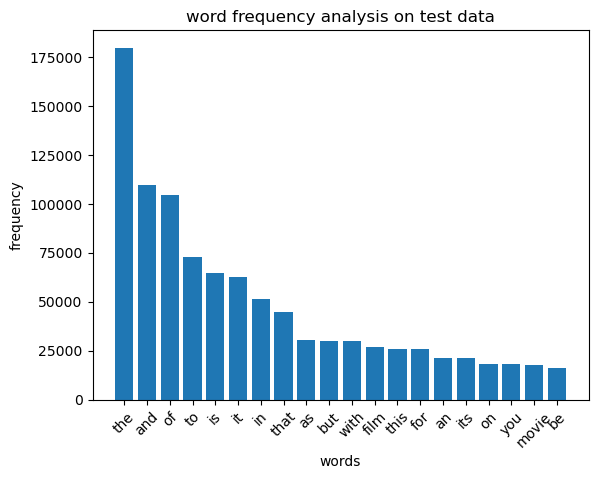

In [13]:
# load the reviewText column form test data.
reviewText_test = df_test['reviewText'].tolist()

matrix_of_test_word = vectorizer.fit_transform(reviewText_test)

words = vectorizer.get_feature_names_out()
frequency = matrix_of_test_word.sum(axis = 0).tolist()[0]

dict_words_frequency = dict(zip(words, frequency))

most_common_word = sorted(dict_words_frequency.items(), key = lambda x: x[1], reverse = True)[:20]

print(most_common_word)

word, frequecies = zip(*most_common_word)
plt.bar(word, frequencies)
plt.xticks(rotation = 45)
plt.xlabel('words')
plt.ylabel('frequency')
plt.title('word frequency analysis on test data')

# **2. Baseline models**

> Establish a performance benchmark.

In [14]:
# Sentiments and labels.
sentiments = df_train['sentiment']
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(sentiments)

# Features and target label.
features = df_train['reviewText']
target = label

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create a pipeline.
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

# Train the pipeline on the training data.
pipeline.fit(X_train, y_train)

# Make predictions on the test data.
y_pred = pipeline.predict(X_test)

# Evaluate the model.
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print("Baseline Model - Dummy Classifier")
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Classification Report:\n", classification_report_str)


Baseline Model - Dummy Classifier
Accuracy: 0.6714180388301794
F1-score: 0.8034112630495515
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     10696
           1       0.67      1.00      0.80     21856

    accuracy                           0.67     32552
   macro avg       0.34      0.50      0.40     32552
weighted avg       0.45      0.67      0.54     32552



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Overall Nan values.
1.  Total NaN values in "TRAIN" data column of reviewText: 0
2.  Total NaN values in "TEST" data column of reviewText: 0

**By merging the movies database with the df_train, we increase the number of features we can play with and find the insights of any relation any feature have with the target variable.**

In [15]:
# We drop the duplicates the movies dataset has and then merge it with df_train.

movies = movies.drop_duplicates(subset='movieid', keep='first')

# We merge both of them on movieid and keep the first occurence of the row.
df = pd.merge(df_train, movies, on='movieid')

**Checking nan values in df.**

In [16]:
df.isna().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText                  0
sentiment                   0
title                       0
audienceScore           13248
rating                  63724
ratingContents          63724
releaseDateTheaters     35834
releaseDateStreaming    16185
runtimeMinutes           3376
genre                    2438
originalLanguage         3290
director                    0
boxOffice               52776
distributor             40663
soundType               85367
dtype: int64

# **3. Imputation**

**Fill NaN for numerical data on a training data by using SimpleImputer.**
>We can fill the NaN values of those columns which will be required afterwards for processing on it by mean of the column features.

In [17]:
selected_columns = ['audienceScore','runtimeMinutes']

# Initialize the imputer.
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the selected columns.
df[selected_columns] = imputer.fit_transform(df[selected_columns])


**Fill NaN for categorical data on a training data.**
>We can fill the NaN values of those columns which will be required afterwards for processing on it by mean of the column features.

In [18]:
selected_columns = ['rating', 'ratingContents', 'genre', 'originalLanguage', 'distributor', 'soundType']

# create a imputer for fill value with most frequent value.
imputer = SimpleImputer(strategy = 'most_frequent')

df[selected_columns] = imputer.fit_transform(df[selected_columns])

**Dealing with NaN value done.**

# **4. Feature processing**

Coverting sentiments into labels.

**LabelEncoder**

In [19]:
# Label sentiment with '0' and '1'.
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

**Draw the heat map to find any correlation between features and target value.**

In [20]:
num_col = list(df.select_dtypes('number').columns)
num_col

['audienceScore', 'runtimeMinutes', 'label']

**Scale the audienceScore and runtimeMinutes in similar range.**

In [21]:
selected_columns = ['audienceScore', 'runtimeMinutes']
ss = StandardScaler()
df[selected_columns] = ss.fit_transform(df[selected_columns])

# **Heat map**
**Find correlation between them.**

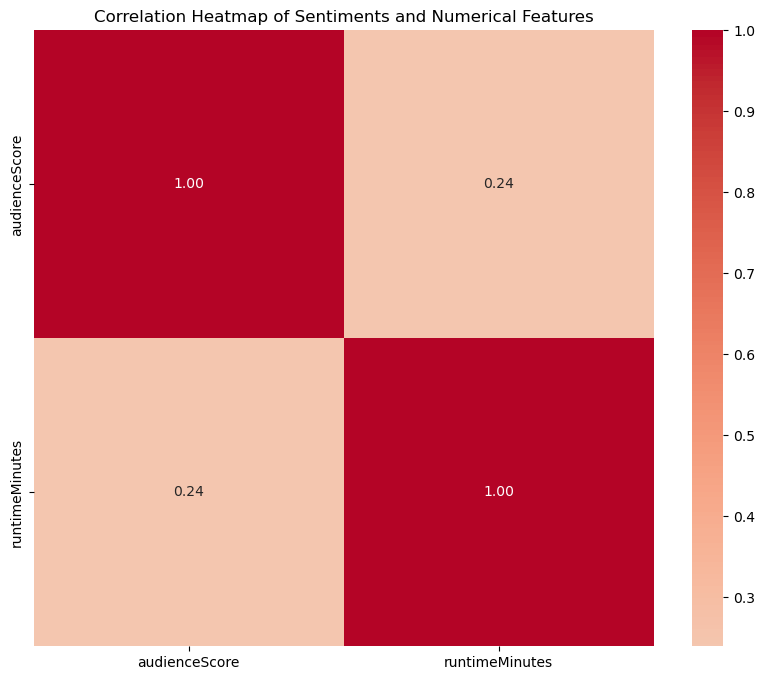

In [22]:
# Select numerical features for correlation analysis
numerical_features = ['audienceScore',
                      'runtimeMinutes']

# Calculate correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Heatmap of Sentiments and Numerical Features")
plt.show()

The plot shows that there is no strong correlation among features and taget_variable.
>  as all values are quite below than 0.5.

**Find correlation for categorical features.**

In [23]:
# find the categorical features.
cat_columns = list(df.select_dtypes(exclude = 'number').columns)
cat_columns

['movieid',
 'reviewerName',
 'isFrequentReviewer',
 'reviewText',
 'sentiment',
 'title',
 'rating',
 'ratingContents',
 'releaseDateTheaters',
 'releaseDateStreaming',
 'genre',
 'originalLanguage',
 'director',
 'boxOffice',
 'distributor',
 'soundType']

# **Cramer V**

In [24]:
# Create a contingency table for the two categorical features
ct = pd.crosstab([ df['reviewText']], df['sentiment'])

# Perform Chi-squared test

chi2, _, _, _ = chi2_contingency(ct)
n = ct.sum().sum()
phi2 = chi2 / n
r, k = ct.shape
cramer = np.sqrt(phi2 / min(r - 1, k - 1))

print("Cramer's:", cramer)
# The value of Cramer's V ranges from 0 to 1, where 0 indicates no association, 
# and 1 indicates a perfect association between the categorical variables.

Cramer's: 0.978576526338299


# **Back to our reviewText feature.**

**Train data**
> **Remove integer values and patterns like "1950s", "1960s", "20s" etc, from the reviewText.**

In [25]:
# Function to remove integer values using regular expressions
def preprocess_text(text):
    # Remove integer values using regex pattern
    processed_text = re.sub(r'\b\d+\b', '', text)
    # Remove specific patterns like "1950s", "1960s", "1970s", etc.
    processed_text = re.sub(r'\b(?:\d+s|20th|21st)\b', '', processed_text)
    return processed_text

# Apply preprocessing to 'reviewText' column
df['reviewText_preprocessed'] = df['reviewText'].apply(preprocess_text)

**Test data.**
> **Remove integer values and patterns like "1950s", "1960s", "20s" etc, from the reviewText.**

In [26]:
# Apply preprocessing to 'reviewText' column on test data.
df_test['reviewText_preprocessed'] = df_test['reviewText'].apply(preprocess_text)

#  **4. Feature Engineering**

**Preprocessing done with our new feature 'reviewText_preprocessed' by TfidfVectorizer.**

**Apply TfidfVectorizer**

In [27]:
# feature column.
X = df[['reviewText_preprocessed']]

# target column.
y = df['label']

# numerical representations of the text data using TfidfVectorizer.
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_vec = vectorizer.fit_transform(X['reviewText_preprocessed'])

# Convert X_vec back to a DataFrame with the remaining columns
# X_numerical = pd.DataFrame(X_vec.toarray(), columns=vectorizer.get_feature_names_out(['reviewText_preprocessed']))

# Transform the test data on the same process as use for train data.
y_review = vectorizer.transform(df_test['reviewText_preprocessed'])


**Data spliting.**
> Split the train preprocessed data for model learning into trainig and testing set.

In [28]:
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2,random_state=42)

# **5. Feature selection.**

**We have quite large number of feature need to be select only relevant feature.**

**We use 'SelectKBest'**

In [29]:
k = 2000
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)

# Apply Feature Selection on validation data
X_test_selected = selector.transform(X_test)

# Apply Feature Selection on test data
y_review_selected = selector.transform(y_review)

# **Model Selection.**
> In sentiment analysis, our goal is to classify text data into different sentiment categories such as positive or negative.
> Conclude that our problem is classification problem.
> > **Candidates for model selection are:**
> > > Naive Bayes, Logistic Regression, Support Vector Machines (SVM), Random Forests, Gradient Boosting Machines (GBM).

# **1. Naive Bayes.**

In [30]:

# # Create and train the naive bayes model.

# model = MultinomialNB()

# model.fit(X_train_selected, y_train)

**Make predictions.**

In [31]:
# # Predict using the trained classifier.
# y_pred = model.predict(X_test_selected)

In [32]:
# np.count_nonzero(y_pred == 0)

In [33]:
# # Make predictions on the testing data
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("F1-score:", f1)



Accuracy: 0.7534713688867043
> F1-score: 0.83790171086917

**Hyperparameter tuning on 'Naive Bayes'.**

In [34]:

# # hyperparameter used.
# param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# # cross-validation
# grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5)
# grid_search.fit(X_train_selected, y_train)

# # evaluate on the test data
# best_alpha = grid_search.best_params_['alpha']
# print("Best Alpha:", best_alpha)

# # create the final model
# final_model = MultinomialNB(alpha=best_alpha)
# final_model.fit(X_train_selected, y_train)

# # Make predictions on the test data.
# y_pred = final_model.predict(X_test_selected)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# **2. Logistic Regression.**

In [35]:
# Create and train the logistic regression model.
model = LogisticRegression()
model.fit(X_train_selected, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
# #Predict using the trained classifier.
# y_pred = model.predict(X_test_selected)

In [37]:
# num_folds = 5  
# scoring_metric = 'accuracy' 

# # Perform cross-validation
# cv_scores = cross_val_score(model, X_train_selected, y_train, cv=num_folds, scoring=scoring_metric)

In [38]:
# mean_cv_score = np.mean(cv_scores)
# std_cv_score = np.std(cv_scores)


In [39]:
# print(f'Cross-Validation {scoring_metric} Scores: {cv_scores}')
# print(f'Mean {scoring_metric} Score: {mean_cv_score}')
# print(f'Standard Deviation of {scoring_metric} Scores: {std_cv_score}')

**Error Analysis.**

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

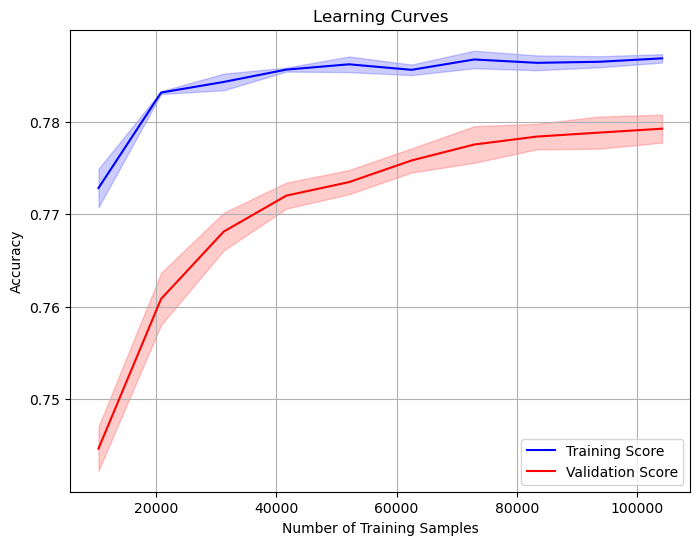

In [40]:
# number of data points to use for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)  # Use 10 evenly spaced values from 10% to 100% of the data

# Compute the learning curve scores
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_selected, y_train, train_sizes=train_sizes, cv=5, scoring='accuracy'
)

# the mean and standard deviation of the train and validation scores
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)
std_val_scores = np.std(val_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, mean_train_scores, label='Training Score', color='blue')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2, color='blue')
plt.plot(train_sizes, mean_val_scores, label='Validation Score', color='red')
plt.fill_between(train_sizes, mean_val_scores - std_val_scores, mean_val_scores + std_val_scores, alpha=0.2, color='red')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()


**Inspect Misclassified Examples**

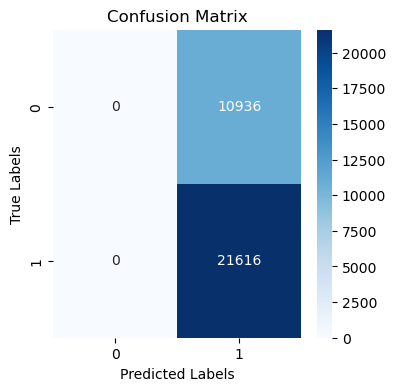

In [41]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Inverse transform of TF-IDF vectors.
original_text_reviews = vectorizer.inverse_transform(X_test.toarray())

# Convert original_text_reviews
original_text_reviews = np.array(original_text_reviews)

# Dictionary to hold misclassified text.
misclassified_dict = {}

# Populate the dictionary with misclassified.
misclassified_indices = (y_test != y_pred)
for review, true_label in zip(original_text_reviews[misclassified_indices], y_test[misclassified_indices]):
    misclassified_text = ' '.join(review)
    misclassified_dict[misclassified_text] = true_label

/tmp/ipykernel_20/205954553.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  original_text_reviews = np.array(original_text_reviews)


In [43]:
# Convert the misclassified_dict
misclassified_df = pd.DataFrame.from_dict(misclassified_dict, orient='index', columns=['True_Label'])

# Reset the index to rename the 'index' column as 'Misclassified_Review_Text'
misclassified_df = misclassified_df.reset_index().rename(columns={'index': 'Misclassified_Review_Text'})

In [44]:
misclassified_df

,Misclassified_Review_Text,True_Label
0,actors bad endeavor movie moving possibly slow...,0
1,bag joy man shame silly title,0
2,arrives clich com destination familiar perform...,0
3,bad body dialogue fi hits kiss like melodrama ...,0
4,don high makers,0
...,...,...
10365,expected head left love,0
10366,excess exercise just messy,0
10367,affleck biggest busy fallen finding handles ho...,0
10368,apatow point probably problem say stuck,0


**Model Evaluation.**

In [45]:
# # Make predictions on the testing data
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("F1-score:", f1)
# #print("Cross-validation scores:", scores)



Accuracy: 0.7769722290489064
> F1-score: 0.8432507124967614

**Hyperparameter tuning on 'Logistic Regression.**

In [46]:
# hyperparameter are:
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'class_weight': [None, 'balanced']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy on Test Data:", accuracy)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Hyperparameters: {'C': 10.0, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Test Data: 0.7774330302285574


Best Hyperparameters: {'C': 10.0, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
> Accuracy on Test Data: 0.7774330302285574

# **3. SVM**

In [47]:

# # # Create an SVM classifier
# svm = SVC()

# # # Fit the SVM model on the training data
# svm.fit(X_train_selected, y_train)


In [48]:
# predictions = svm.predict(X_test_selected)

# # Calculate the accuracy of the model
# accuracy = accuracy_score(y_test, predictions)
# f1 = f1_score(y_test, predictions)

# print("Accuracy:", accuracy)
# print("F1-score:", f1)

Accuracy: 0.7782317522732858
> F1-score: 0.8443409448649115

**SVM Hyperparameter tuning.**

In [49]:
# # Define the hyperparameter grid to search
# svm = SVC()
# param_grid = {
#     'C': [0.1, 1, 10, 100],           # Different values of C
#     'kernel': ['linear', 'rbf'],      # Linear and RBF kernels
#     'gamma': ['scale', 'auto']        # Different gamma options for RBF kernel
# }

# # Create a GridSearchCV
# grid_search = GridSearchCV(estimator = svm, param_grid=param_grid, cv=5, n_jobs=-1)

# # Perform the Grid Search on the training data
# grid_search.fit(X_train_selected, y_train)

# # Get the best hyperparameters found by Grid Search
# best_params = grid_search.best_params_

# # Train the SVM model with the best hyperparameters
# best_svm_classifier = SVC(**best_params)
# best_svm_classifier.fit(X_train_selected, y_train)

# # Make predictions on the testing data
# y_pred = best_svm_classifier.predict(X_test_selected)

# # Evaluate the model performance
# accuracy = accuracy_score(y_test, y_pred)
# print("Best SVM Hyperparameters:", best_params)
# print("Accuracy:", accuracy)


# **4. Decision Tree**

In [50]:
# # Create DecisionTreeClassifier classifier.
# model = DecisionTreeClassifier()
# model.fit(X_train_selected,y_train)

In [51]:
# # Make predictions.
# y_pred = model.predict(X_test_selected)
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print("F1-score:", f1)

**Hyperparameter tuning for Decision tree**

In [52]:
# param_grid = {
#     'max_depth': [ 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv=5)

# # Fit the GridSearchCV on the training data
# grid_search.fit(X_train_selected, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Access the best model.
# best_model = grid_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_model.predict(X_test_selected)

# # Evaluate the model's performance
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print("F1-score:", f1)

Accuracy: 0.67169451953797
> F1-score: 0.7963566378932526

# **5. KNN**

In [53]:
# # Create and train the KNN model.

# knn = KNeighborsClassifier()
# knn.fit(X_train_selected, y_train)


In [54]:
# # Predict using the trained classifier.
# y_pred = knn.predict(X_test_selected)

# # Make predictions on the testing data
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print("F1-score:", f1)

Accuracy: 0.6787601376259523
> F1-score: 0.7664649261897849

**Hyperparameter tuning for KNN.**

In [55]:
# # hyperparameter are:
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9],  
#     'metric': ['euclidean', 'manhattan'] 
# }

# # cross-validation
# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search on your training data
# grid_search.fit(X_train_selected, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Retrieve the best model
# best_knn_model = grid_search.best_estimator_

# # Make predictions on the validation data
# y_pred_val = best_knn_model.predict(X_test_selected)

# # Evaluate the model performance on the validation data
# accuracy_val = accuracy_score(y_val, y_pred_val)
# print("Validation Accuracy:", accuracy_val)

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 9}
> Validation Accuracy: 0.6931371344310642


# **6. Bagging algo with decision tree classifier.**

In [56]:
# # Create and train the bagging classifier.

# base_classifier = DecisionTreeClassifier() 
# bagging = BaggingClassifier(base_classifier, n_estimators=10, random_state=42) 
# bagging.fit(X_train_selected, y_train)


In [57]:
# # Make predictions

# y_pred = bagging.predict(X_test_selected)
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print("F1-score:", f1)

Accuracy: 0.7135352666502827
> F1-score: 0.789660072632125


**Hyperparameter tuning for begging algo.**

In [58]:

# # Create the base estimator (Decision Tree Classifier)
# base_estimator = DecisionTreeClassifier()

# # Create the Bagging classifier
# bagging_classifier = BaggingClassifier(base_estimator=base_estimator, random_state=42)

# # Define the hyperparameter grid to explore
# param_grid = {
#     'n_estimators': [50, 100, 200], 
#     'base_estimator__max_depth': [None, 3, 5], 
#     'base_estimator__min_samples_split': [2, 5, 10],
# }

#  cross-validation
# grid_search = GridSearchCV(bagging_classifier, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search on your training data
# grid_search.fit(X_train, y_train)


# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

 
# best_bagging_model = grid_search.best_estimator_


# y_pred_val = best_bagging_model.predict(X_val)

# # Evaluate the model performance on the validation data
# accuracy_val = accuracy_score(y_val, y_pred_val)
# print("Validation Accuracy:", accuracy_val)


# **7. Boosting algorithm.**
> * AdaBoost
> * GradientBoost

In [59]:
# # Create and apply adaboostclassifier.

# ada_boost = AdaBoostClassifier(n_estimators = 50, random_state = 42)
# ada_boost.fit(X_train, y_train)

In [60]:
# # Make prediction for adaboost.

# y_pred = ada_boost.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print("F1-score:", f1)

Accuracy: 0.6969771442614893
> F1-score: 0.8072835261019068

In [61]:
# grad_boost = GradientBoostingClassifier(n_estimators = 100, random_state = 42)
# grad_boost.fit(X_train, y_train)


In [62]:
# # Make prediction for gradientboost.

# y_pred = grad_boost.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print("F1-score:", f1)

Accuracy: 0.6899729663307939
> F1-score: 0.8089938678173972

**Hyperparameter tuning for adaboost.**

In [63]:
# # Create the base estimator
# base_estimator = DecisionTreeClassifier(max_depth=1)

# # Create the AdaBoost classifier
# adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

# # Define the hyperparameter grid to explore
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.05, 0.1, 0.2],
# }

# # Create the GridSearchCV
# grid_search = GridSearchCV(adaboost_classifier, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Retrieve the best model with the best hyperparameters
# best_adaboost_model = grid_search.best_estimator_

# # Make predictions on the test data
# y_pred_test = best_adaboost_model.predict(X_test)

# # Evaluate the model performance on the test data
# accuracy_test = accuracy_score(y_test, y_pred_test)
# print("Test Accuracy:", accuracy_test)


**Hyperparameter tuning for GradientBoost.**

In [64]:
# # Create the Gradient Boosting classifier
# gb_classifier = GradientBoostingClassifier()

# # Define the hyperparameter grid to explore
# param_grid = {
#     'n_estimators': [50, 100, 200],  
#     'learning_rate': [0.05, 0.1, 0.2],  
#     'max_depth': [3, 4, 5], 
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, scoring='accuracy')

# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Retrieve the best model with the best hyperparameters
# best_gb_model = grid_search.best_estimator_

# # Make predictions on the validation data
# y_pred_val = best_gb_model.predict(X_val)

# # Evaluate the model performance on the validation data
# accuracy_val = accuracy_score(y_val, y_pred_val)
# print("Validation Accuracy:", accuracy_val)


**Adaboost with base estimator.**

In [65]:
# # Create the base estimator
# base_estimator = DecisionTreeClassifier(max_depth=3) 

# # Create the AdaBoost classifier with the base estimator
# adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)

# # Train the AdaBoost classifier on the training data
# adaboost_classifier.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = adaboost_classifier.predict(X_test)

# # Evaluate the model performance
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

Accuracy: 0.7187576800196609

**Gradientboost with base estimator.**
> sklearn doesn't have any base estimator for Gradientboost instead it uses default base estimator i.e. decision tree.

# **8. Multi Layer Perceptron algorithm.**

In [66]:
# # Create and train the MLPClassifier.
# mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)  

# # Adjust the hidden_layer_sizes
# mlp.fit(X_train_selected, y_train)

In [67]:
# # Make predictions.

# y_pred = mlp.predict(X_test_selected)

# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print('Accuracy:', accuracy)
# print("F1-score:", f1)

Accuracy: 0.7396473334971737
> F1-score: 0.81192161736313

**Hyperparameter tuning for MLP.**

In [68]:
# # Create the MLP classifier
# mlp_classifier = MLPClassifier()

# # Define the hyperparameter grid to explore
# param_grid = {
#     'hidden_layer_sizes': [(100,), (100, 50)],  # Try different architectures
#     'alpha': [0.0001, 0.001, 0.01],  # Try different regularization terms
#     'learning_rate_init': [0.001, 0.01, 0.1],  # Try different initial learning rates
#     'max_iter': [100, 200, 300]  # Try different numbers of epochs
# }

# # Create the GridSearchCV object with cross-validation
# random_search = RandomizedSearchCV(mlp_classifier, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search on your training data (X_train, y_train)
# random_search.fit(X_train, y_train)

# # Get the best hyperparameters found during grid search
# best_params = random_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Retrieve the best model with the best hyperparameters
# best_mlp_model = random_search.best_estimator_

# # Make predictions on the validation data
# y_pred_val = best_mlp_model.predict(X_val)

# # Evaluate the model performance on the validation data
# accuracy_val = accuracy_score(y_val, y_pred_val)
# print("Validation Accuracy:", accuracy_val)


# **9. RandomForest**

In [69]:

# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier on the training data
# model = rf_classifier.fit(X_train_selected, y_train)

# # Make predictions on the test data
# y_pred = model.predict(X_test_selected)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# classification_report_str = classification_report(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("F1-score:", f1)
# print("Classification Report:\n", classification_report_str)


Accuracy: 0.7365446055541902
> F1-score: 0.813012384440956

In [70]:
# np.count_nonzero(y_pred ==0)

**Hyperparameter for RandomForest.**

In [71]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt']
# }

# # Create a RandomForestClassifier
# rf_model = RandomForestClassifier(random_state=42)

# # Create the GridSearchCV object
# random_search = RandomizedSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the training data
# random_search.fit(X_train, y_train)

# # Get the best hyperparameters and model
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_

# # Evaluate the best model on the test data
# accuracy = best_model.score(X_test, y_test)

In [72]:
# y_pred = best_model.predict(y_features)

# # Print the predictions
# print("Predictions for New Data:")
# print(predictions)

In [73]:
# import os
# os.remove("./submission.csv")

In [74]:
# Prediction on y_test.
y_pred = best_model.predict(y_review_selected)
out=pd.DataFrame(y_pred)

In [75]:
out.rename(columns = {0:'sentiment'}, inplace = True)
out=out.reset_index()
out.rename(columns = {'index':'id'}, inplace = True)

In [76]:
def convert_sentiment(sentiment):
    sentiment_mapping = {
        1 : 'POSITIVE',
        0 : 'NEGATIVE'
    }
    return sentiment_mapping.get(sentiment, 0)

# Convert sentiment labels to numerical values
out['sentiment'] = out['sentiment'].apply(convert_sentiment)

In [77]:
out.to_csv('submission.csv',index=False)